# Cat VS Dog Dataset Classification
---

## Data:

[Kaggle: Cat VS Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset)

## 1. Setup

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib

In [1]:
# Genral
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# Nueral Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 2. Data Exploration

In [2]:
data_dir = "data/PetImages"

### Basic Info

In [3]:
# Imágenes de Gato
len(os.listdir("data/PetImages/Cat/"))

12490

In [4]:
# Imágenes de Perro
len(os.listdir("data/PetImages/Dog/"))

12469

### Images

In [5]:
cat_img = mpimg.imread("data/PetImages/Cat/0.jpg")

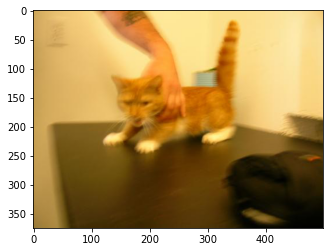

In [6]:
plt.imshow(cat_img)

In [7]:
dog_img = mpimg.imread("data/PetImages/Dog/0.jpg")

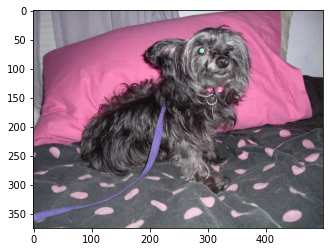

In [9]:
plt.imshow(dog_img)

## 3. Preprocessing

In [10]:
class_names = ["Cat", "Dog"]

In [11]:
batch_size = 32
img_height = 180
img_width = 180

### 3.1 Train Dataset

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print(train_ds.class_names)

Found 24959 files belonging to 2 classes.
Using 19968 files for training.
['Cat', 'Dog']


### 3.2 Validation Dataset

In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print(val_ds.class_names)

Found 24959 files belonging to 2 classes.
Using 4991 files for validation.
['Cat', 'Dog']


### 3.3 Visualization

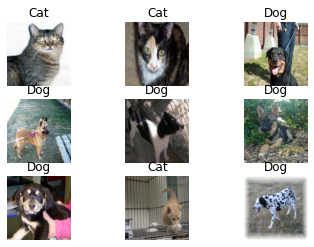

In [14]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## 4. Config for Performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Standardize the layers
normalization_layer = layers.Rescaling(1./255)

## 5. Model Creation

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## 6. Test Training

In [29]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

624/624 [==============================] - 169s 268ms/step - loss: 7.6791 - accuracy: 0.5036 - val_loss: 7.4581 - val_accuracy: 0.4891


### 6.1 Visualization

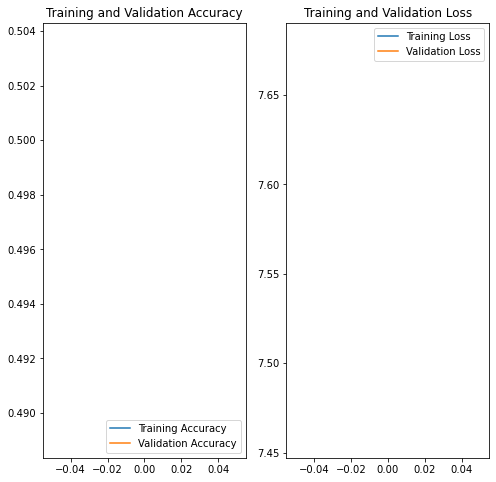

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

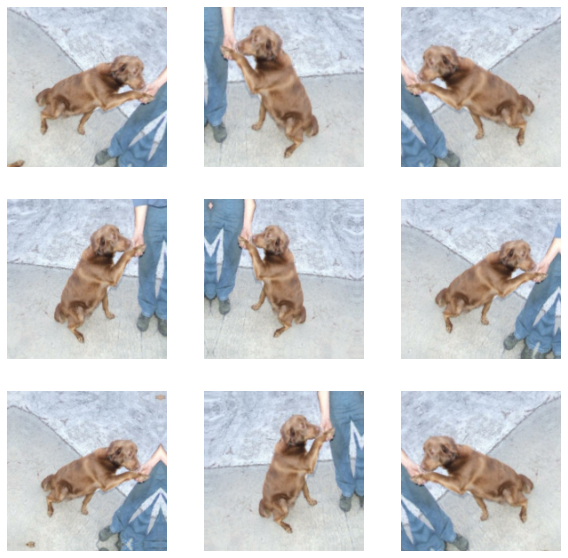

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [42]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

624/624 [==============================] - 182s 292ms/step - loss: 0.5358 - accuracy: 0.7314 - val_loss: 0.4779 - val_accuracy: 0.7744


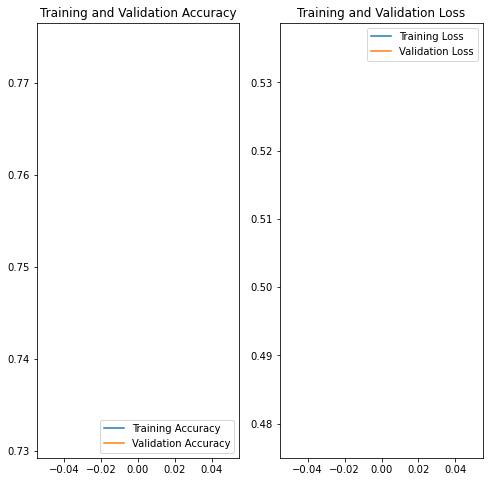

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()